# CSET419 – Introduction to Generative AI  
## Lab – 5  
### Baseline CNN for Image-to-Image Translation (Encoder–Decoder without GAN)

---

## 🎯 Objective

To implement a baseline Encoder–Decoder Convolutional Neural Network (CNN) for paired image-to-image translation and analyze its performance using reconstruction loss.

---

## 📌 Experiment Tasks

1. Load paired images (CIFAR10 dataset)  
2. Normalize images to range [-1, 1]  
3. Train an Encoder–Decoder CNN  
4. Compute reconstruction loss (MSE / L1)  
5. Visualize translated (reconstructed) images  

---

## 📂 Dataset

**CIFAR10 Dataset**

- 60,000 RGB images  
- Image size: 32 × 32  
- 10 object classes  
- Used in paired setting (Input = Target image)

---

## 🧠 Model Architecture

### Encoder
- Conv2D (3 → 64), ReLU  
- Conv2D (64 → 128), ReLU  

### Decoder
- ConvTranspose2D (128 → 64), ReLU  
- ConvTranspose2D (64 → 3), Tanh  

The final activation is **Tanh** to ensure output is in range [-1, 1].

---

## 📉 Loss Function

Reconstruction Loss:

- Mean Squared Error (MSE)  
or  
- L1 Loss  

The model minimizes the difference between the input image and reconstructed image.

---

## ⚙️ Training Configuration

- Optimizer: Adam  
- Learning Rate: 0.001  
- Epochs: 5  
- Batch Size: 16  
- Device: CPU / GPU  

---

## 📊 Results & Observation

- The reconstructed images appear slightly blurry.
- Pixel-wise reconstruction losses (MSE/L1) cause smoothing.
- No adversarial training is used.

---

## ✅ Conclusion

The baseline Encoder–Decoder CNN successfully reconstructs CIFAR10 images.  
However, outputs are blurry due to pixel-wise loss limitations.

To improve results:
- Use U-Net (skip connections)
- Use GAN-based training
- Use perceptual loss


Using device: cuda
Epoch [1/5]  Loss: 0.0038
Epoch [2/5]  Loss: 0.0009
Epoch [3/5]  Loss: 0.0006
Epoch [4/5]  Loss: 0.0005
Epoch [5/5]  Loss: 0.0004
Training Completed


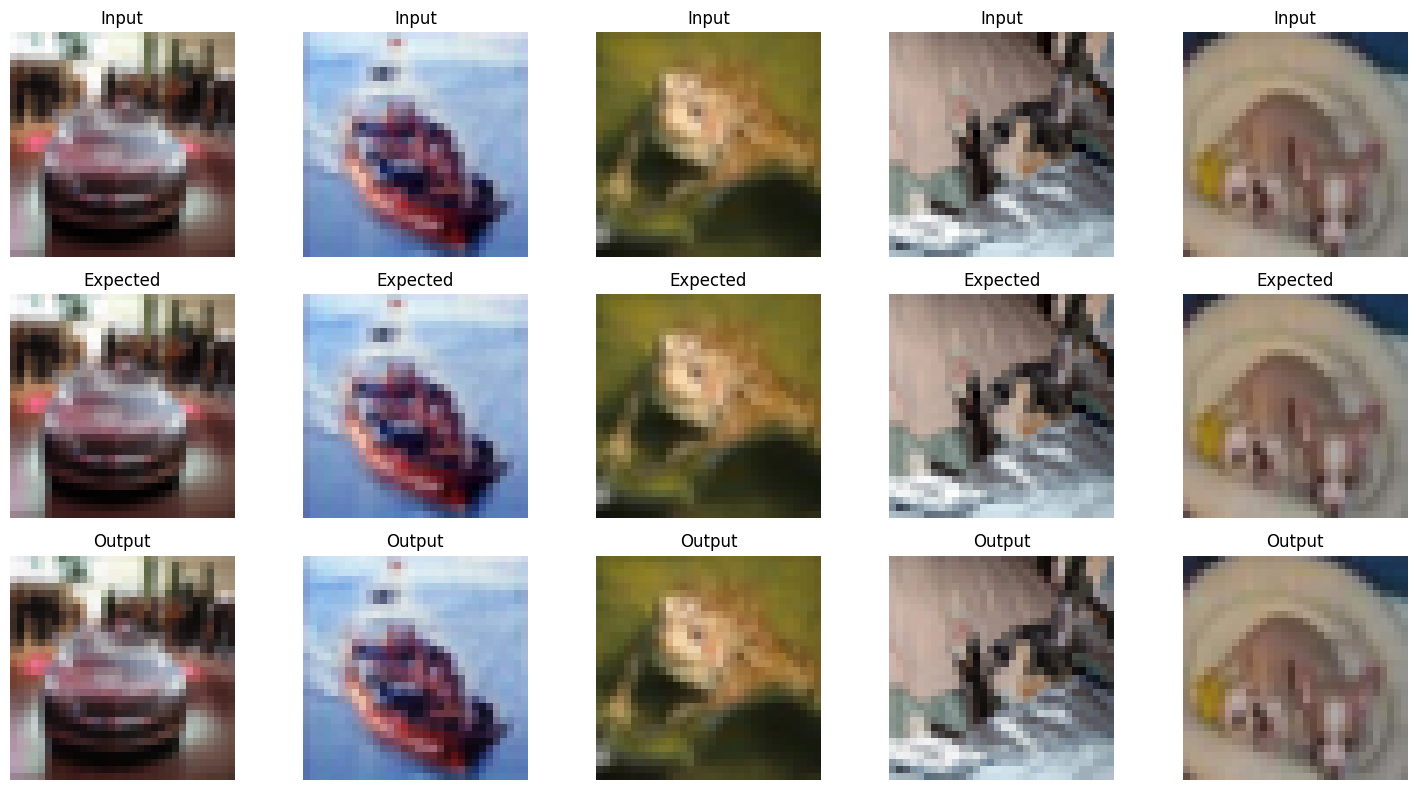

In [3]:
# ==========================================================
# CSET419 – Introduction to Generative AI
# Lab – 5
# Baseline CNN for Image-to-Image Translation
# Encoder–Decoder without GAN
# ==========================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# 1. Device Configuration
# ----------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------------------------------------
# 2. Load CIFAR10 Dataset (Paired Setting)
# Normalize images to [-1, 1]
# ----------------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))   # Scale to [-1,1]
])

dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,
    shuffle=True
)

# ----------------------------------------------------------
# 3. Define Encoder–Decoder CNN
# ----------------------------------------------------------
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()   # Output in [-1,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = EncoderDecoder().to(device)

# ----------------------------------------------------------
# 4. Loss and Optimizer
# ----------------------------------------------------------
criterion = nn.MSELoss()   # Reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ----------------------------------------------------------
# 5. Training Loop
# ----------------------------------------------------------
epochs = 5

for epoch in range(epochs):
    running_loss = 0.0

    for images, _ in dataloader:
        images = images.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        # Paired translation: Input = Target
        loss = criterion(outputs, images)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}]  Loss: {running_loss/len(dataloader):.4f}")

print("Training Completed")

# ----------------------------------------------------------
# 6. Clear Visualization
# Input | Expected | Output
# ----------------------------------------------------------
model.eval()

with torch.no_grad():
    sample_images, _ = next(iter(dataloader))
    sample_images = sample_images.to(device)
    outputs = model(sample_images)

# Convert from [-1,1] back to [0,1]
inputs = (sample_images + 1) / 2
expected = inputs.clone()        # Ground truth = input (reconstruction task)
outputs = (outputs + 1) / 2

inputs = inputs.cpu()
expected = expected.cpu()
outputs = outputs.cpu()

num_images = 5

plt.figure(figsize=(15, 8))

for i in range(num_images):

    # -------- Input --------
    plt.subplot(3, num_images, i + 1)
    plt.imshow(inputs[i].permute(1, 2, 0))
    plt.title("Input")
    plt.axis("off")

    # -------- Expected --------
    plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(expected[i].permute(1, 2, 0))
    plt.title("Expected")
    plt.axis("off")

    # -------- Output --------
    plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(outputs[i].permute(1, 2, 0))
    plt.title("Output")
    plt.axis("off")

plt.tight_layout()
plt.show()

# ==========================================================
# Explanation:
# Input     = Real CIFAR10 Image
# Expected  = Same Image (Reconstruction Task)
# Output    = Model Reconstructed Image (Slightly Blurry)
# ==========================================================
